In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-07-25 23:11:57


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf

from   invisible_cities.evm.ic_containers           import S12Params 
from   invisible_cities.evm.ic_containers          import CalibVectors
from   invisible_cities.evm.ic_containers          import DeconvParams
from   invisible_cities.evm.ic_containers          import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
from   invisible_cities.types.ic_types import Counter
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.icaro.pmaps_mpl import plot_s2si_map

In [4]:
import invisible_cities.icaro.mpl_functions as mpl

In [5]:
import invisible_cities.evm.event_model as evm

In [6]:
from invisible_cities.evm.pmaps import S12
from invisible_cities.evm.pmaps import S1
from invisible_cities.evm.pmaps import S2
from invisible_cities.evm.pmaps import S2Si

In [7]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound

In [8]:
run_number = -4446
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [9]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [10]:
RWF_file = os.path.join(os.environ['IC_DATA'], 'MC_PreProd_July_2017',
                        'dst_NEXT_v1_00_05_Cs_ACTIVE_0_0_7bar_RWF_10.h5')
print('RWF file = {}'.format(RWF_file))

RWF file = /Users/jjgomezcadenas/Projects/ICDATA/MC_PreProd_July_2017/dst_NEXT_v1_00_05_Cs_ACTIVE_0_0_7bar_RWF_10.h5


In [11]:
h5rwf = tb.open_file(RWF_file,'r')

In [12]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
NEVT, pmtrwf, sipmrwf, _ = tbl.get_rwf_vectors(h5rwf)
sp = tbl.get_sensor_params_from_vectors(pmtrwf, sipmrwf)
print(sp)

####################
SensorParams
####################
npmt: 12
pmtwl: 48000
nsipm: 1792
sipmwl: 1200



### Reconstruction Parameters

In [13]:
calib_vectors = CalibVectors(channel_id = DataPMT.ChannelID.values,
                             coeff_blr = abs(DataPMT.coeff_blr   .values),
                             coeff_c = abs(DataPMT.coeff_c   .values),
                             adc_to_pes = DataPMT.adc_to_pes.values,
                             adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                             pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist())


deconv_params = DeconvParams(n_baseline = 45000,
                              thr_trigger = 5)

s1par = S12Params(time = minmax(min    = 99 * units.mus,
                           max    = 101 * units.mus),
                           stride = 4,
                           length = minmax(min = 6, max = 30),  #150 ns -- 500 ns
                           rebin  = False)

s2par = S12Params(time = minmax(min    = 101 * units.mus,
                           max    = 1199 * units.mus),
                           stride = 40,
                           length = minmax(min = 120, max = 1e5),  # 4 mus --
                           rebin  = True)

thresholds = ThresholdParams(thr_s1=2 * units.pes,
                      thr_s2=1.0 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=1.5*units.pes,
                      thr_SIPM=15*units.pes)



In [14]:
event = 0

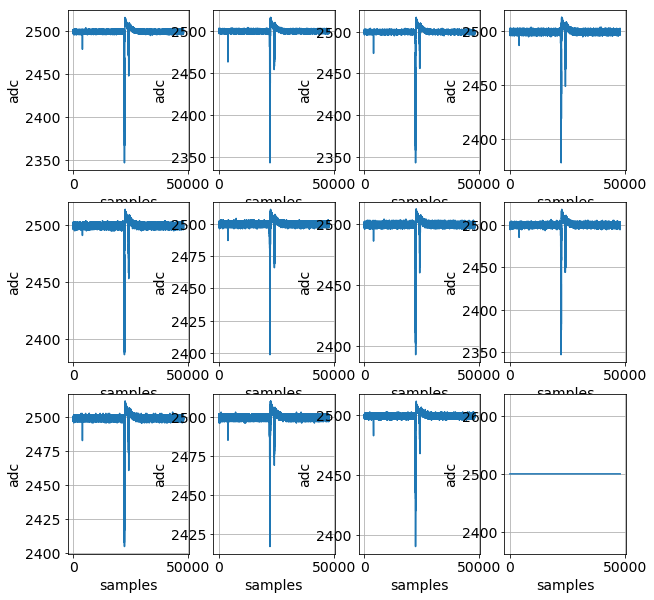

In [15]:
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))

#### Deconvolution

In [16]:
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)

#### csum

In [17]:
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)

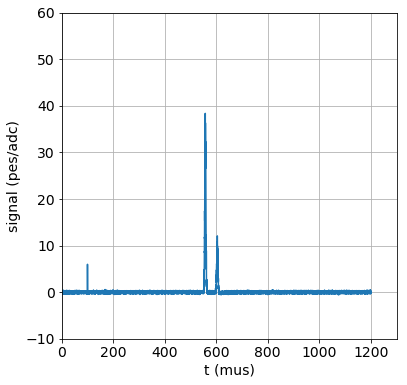

In [20]:
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  60,
                        figsize=(6,6))

#### S1 and S2

In [21]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)

In [22]:
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())


In [23]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 7 width =      0.1 mus , energy =     31.4 pes
        height =      6.0 pes tmin-tmax = minmax(min=100.075, max=100.22500000000001) mus  

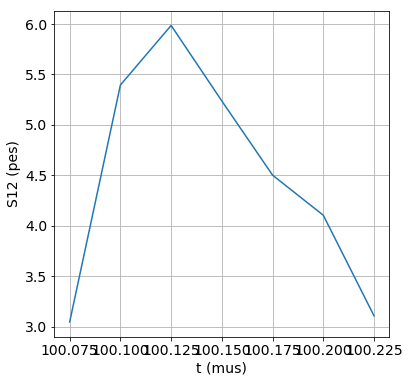

In [24]:
plot_s12(s1)

In [25]:
s2

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 12 width =     10.8 mus , energy =   7367.8 pes
        height =   1385.2 pes tmin-tmax = minmax(min=552.525, max=563.2875) mus  
peak number = 1: Peak(samples = 11 width =      9.4 mus , energy =   2134.1 pes
        height =    370.0 pes tmin-tmax = minmax(min=599.8125, max=609.2) mus  

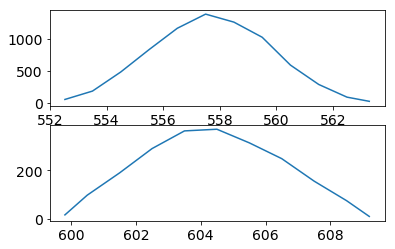

In [26]:
plot_s12(s2)

#### S2Si

In [27]:
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)

In [28]:
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)

In [29]:
s2si

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 12 width =     10.8 mus , energy =   7367.8 pes
        height =   1385.2 pes tmin-tmax = minmax(min=552.525, max=563.2875) mus  
peak number = 1: Peak(samples = 11 width =      9.4 mus , energy =   2134.1 pes
        height =    370.0 pes tmin-tmax = minmax(min=599.8125, max=609.2) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1122, 1123, 1124, 1130, 1131, 1132, 1138, 1139, 1140, 1147)

peak number = 1: nsipm in peak = (1134, 1135, 1142, 1143)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1122
    sipm waveform (zs) = Peak(samples = 7 width =      7.0 mus , energy =     31.1 pes
        height =      7.8 pes tmin-tmax = minmax(min=552.525, max=559.5) mus 
peak number = 0: sipm number = 1123
    sipm waveform (zs) = Peak(samples = 7 width =      6.

In [30]:
s2si.number_of_peaks

2

In [31]:
s2si.sipms_in_peak(0)

(1122, 1123, 1124, 1130, 1131, 1132, 1138, 1139, 1140, 1147)

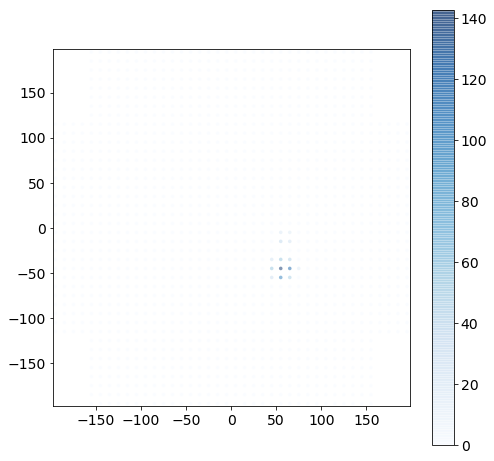

In [32]:
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      0.2 mus , energy =     44.6 pes
        height =      7.5 pes tmin-tmax = minmax(min=100.075, max=100.25) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 13 width =     11.6 mus , energy =   8658.8 pes
        height =   1488.9 pes tmin-tmax = minmax(min=589.725, max=601.3625000000001) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 13 width =     11.6 mus , energy =   8658.8 pes
        height =   1488.9 pes tmin-tmax = minmax(min=589.725, max=601.3625000000001) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (104, 105, 112, 113, 114, 120, 121, 175, 183, 191, 320, 321, 391)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 104
    sipm waveform (zs) = Peak(samples = 8 width =      7.0 mus , energy =     48.8

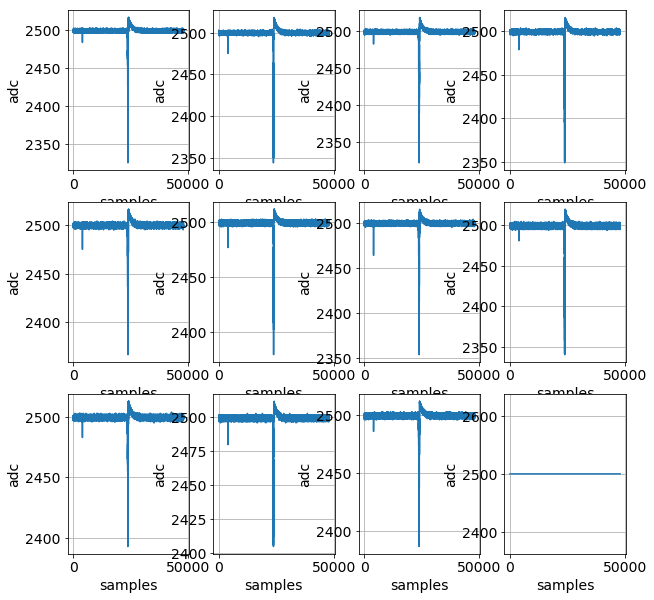

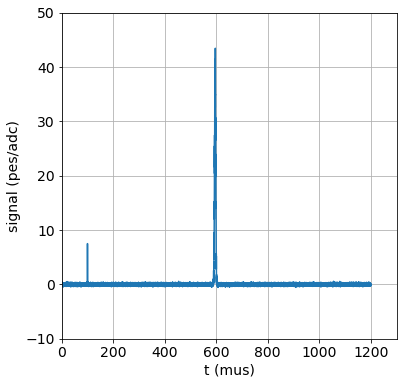

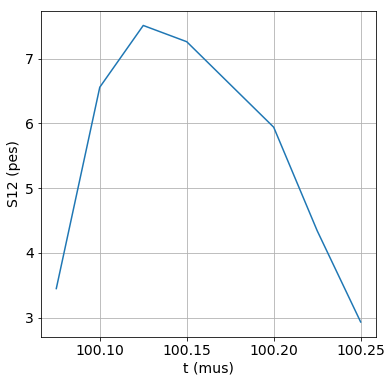

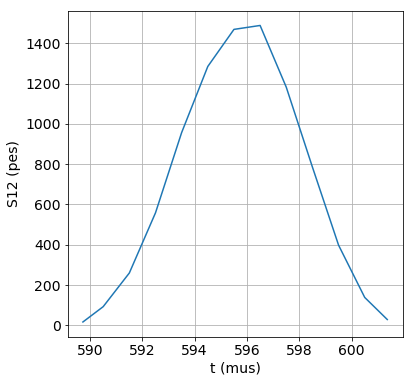

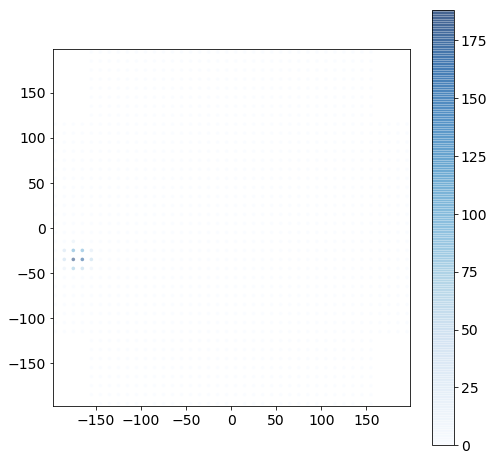

In [33]:
event = 1
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  50,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 9 width =      0.2 mus , energy =     65.1 pes
        height =     10.8 pes tmin-tmax = minmax(min=100.075, max=100.275) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 20 width =     18.4 mus , energy =  16316.5 pes
        height =   2012.6 pes tmin-tmax = minmax(min=538.7375, max=557.0875) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 20 width =     18.4 mus , energy =  16316.5 pes
        height =   2012.6 pes tmin-tmax = minmax(min=538.7375, max=557.0875) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (528, 536, 544, 598, 599, 605, 606, 607, 613, 614, 615, 621, 622, 623)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 528
    sipm waveform (zs) = Peak(samples = 6 width =      7.0 mus , energy =     24.5 pes
     

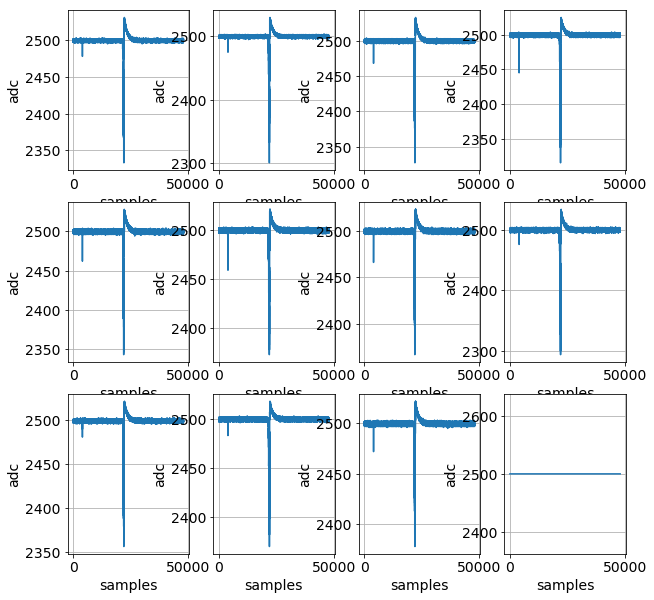

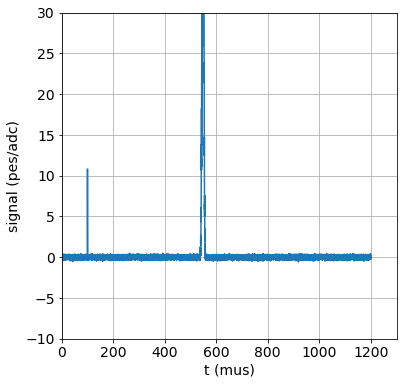

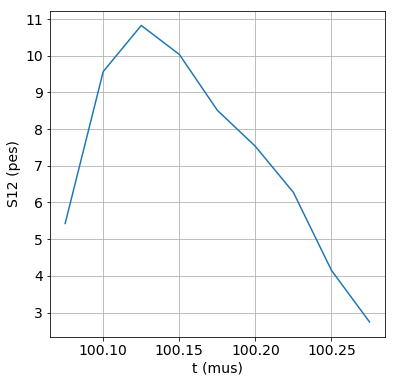

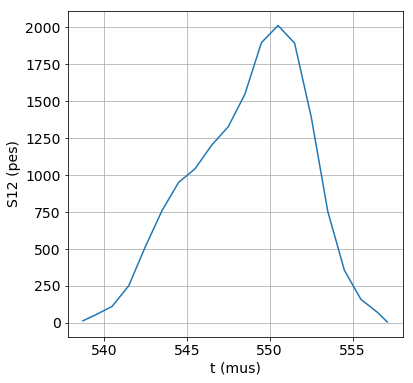

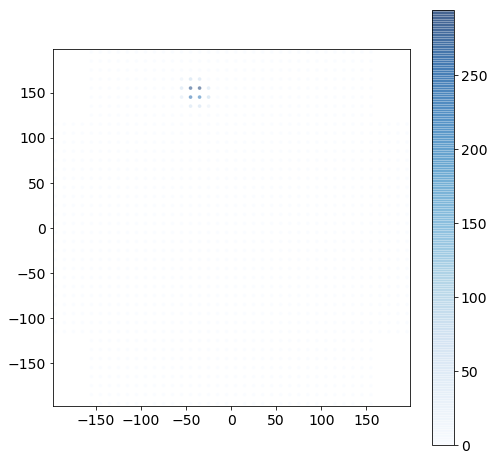

In [34]:
event = 2
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      0.2 mus , energy =     40.1 pes
        height =      6.3 pes tmin-tmax = minmax(min=100.075, max=100.25) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      8.7 mus , energy =  19738.3 pes
        height =   5236.8 pes tmin-tmax = minmax(min=252.6625, max=261.325) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      8.7 mus , energy =  19738.3 pes
        height =   5236.8 pes tmin-tmax = minmax(min=252.6625, max=261.325) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (689, 696, 697, 698, 699, 1024, 1025, 1026, 1027, 1032, 1033, 1034, 1035)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 689
    sipm waveform (zs) = Peak(samples = 5 width =      4.0 mus , energy =     15.2 pes
     

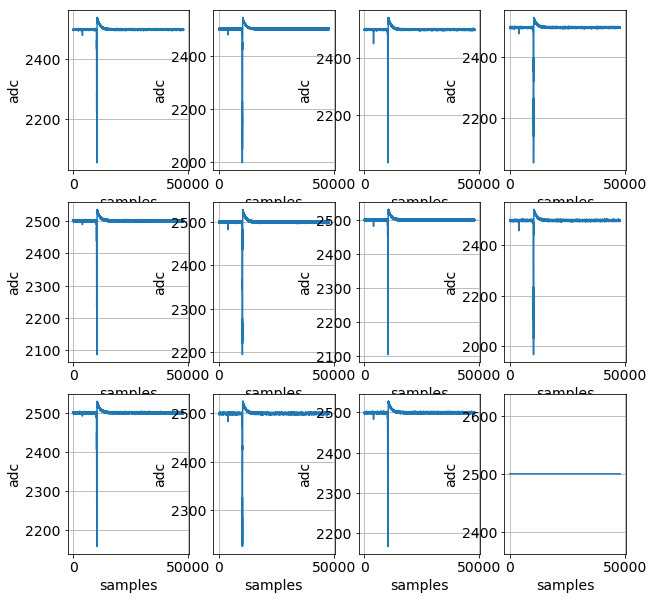

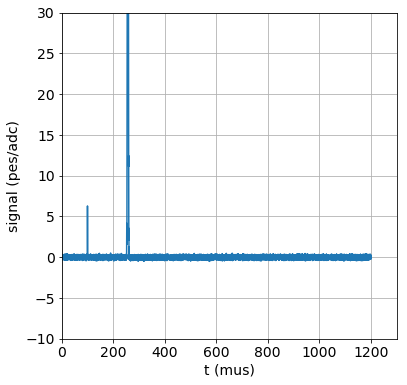

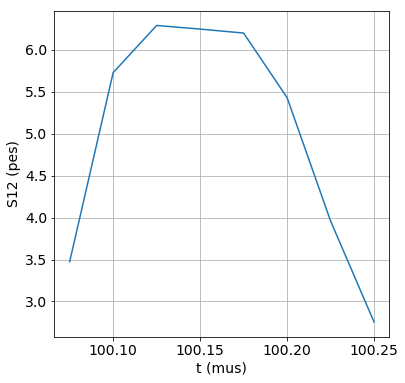

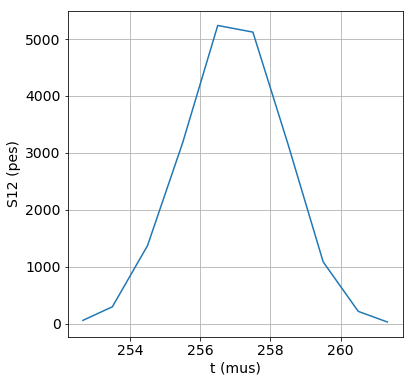

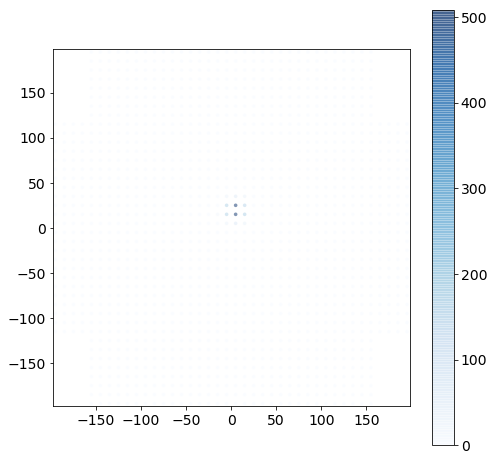

In [35]:
event = 3
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      0.2 mus , energy =      7.6 pes
        height =      1.2 pes tmin-tmax = minmax(min=100.10000000000001, max=100.275) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      6.4 mus , energy =   4322.4 pes
        height =   1212.3 pes tmin-tmax = minmax(min=257.75, max=264.1625) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      6.4 mus , energy =   4322.4 pes
        height =   1212.3 pes tmin-tmax = minmax(min=257.75, max=264.1625) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1436, 1437, 1438, 1444, 1445)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1436
    sipm waveform (zs) = Peak(samples = 6 width =      4.8 mus , energy =     84.4 pes
        height =     29.9 pes tmin-tmax

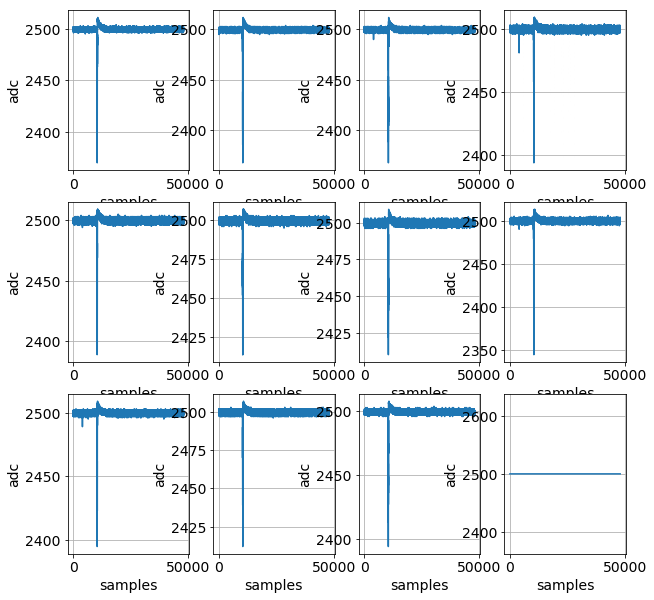

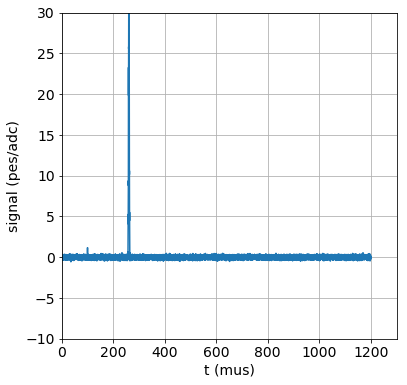

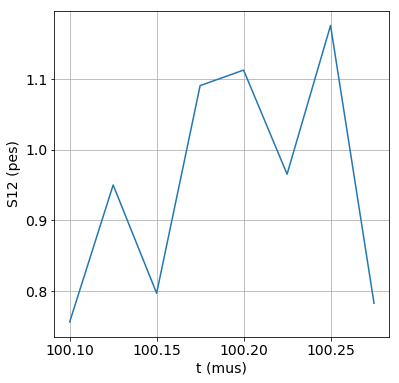

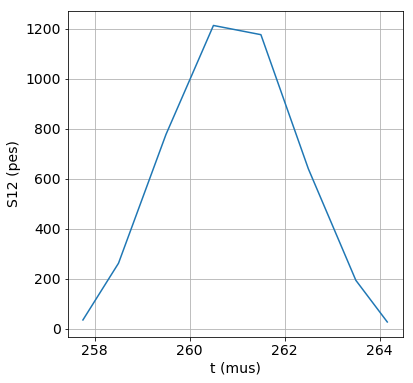

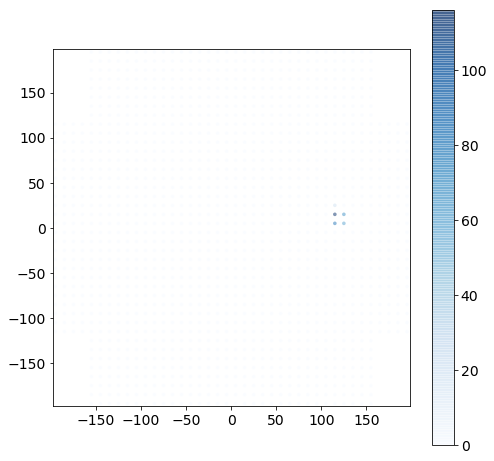

In [40]:
event = 4
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 13 width =      0.3 mus , energy =     79.0 pes
        height =     10.2 pes tmin-tmax = minmax(min=100.075, max=100.375) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 18 width =     16.2 mus , energy =  19422.4 pes
        height =   2883.1 pes tmin-tmax = minmax(min=400.9875, max=417.1625) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 18 width =     16.2 mus , energy =  19422.4 pes
        height =   2883.1 pes tmin-tmax = minmax(min=400.9875, max=417.1625) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (545, 546, 552, 553, 554, 555, 560, 561, 562, 563, 568, 569, 570, 631, 639, 896, 897)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 545
    sipm waveform (zs) = Peak(samples = 7 width =      6.0 mus , energy =   

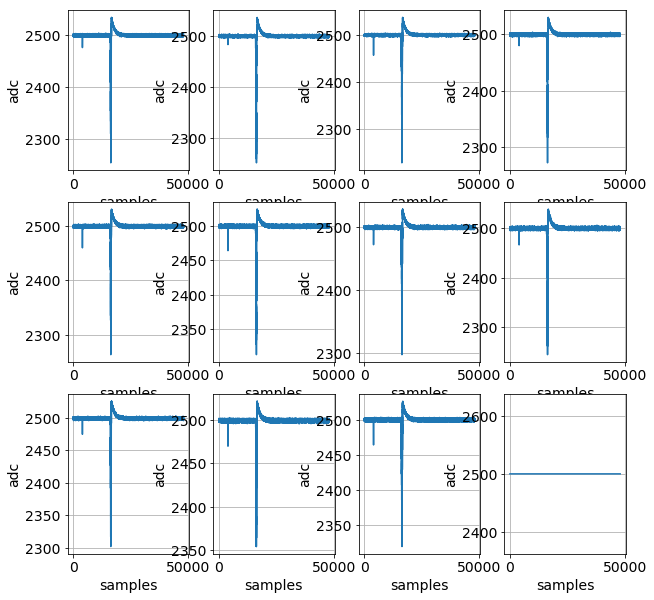

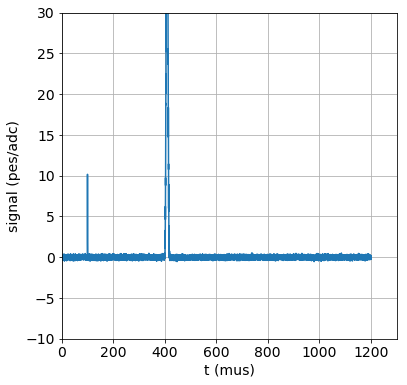

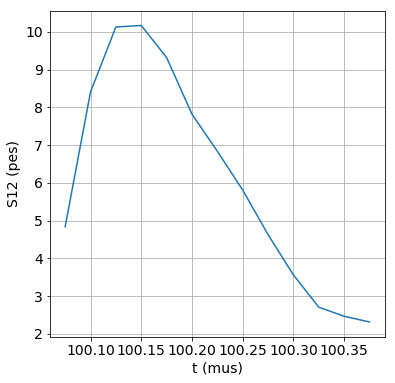

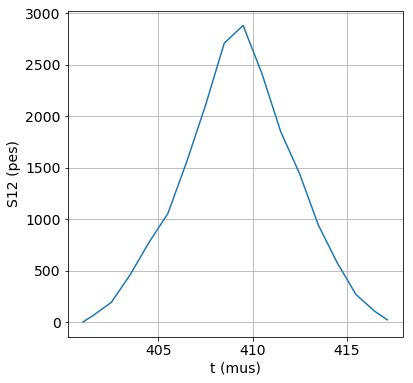

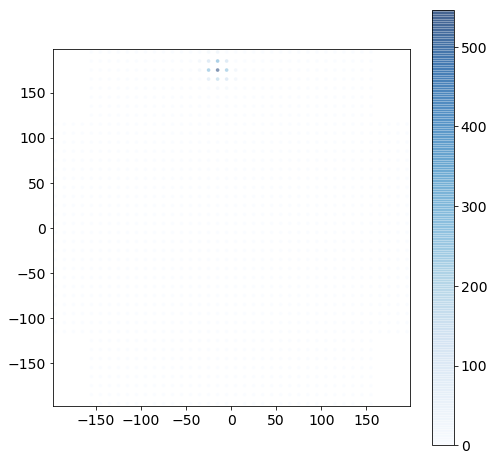

In [36]:
event = 5
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)